In [91]:
import cv2 as cv
import numpy as np
import torch
import sys
from lib.config import cfg
from lib.model import build_model
import lib.scene_parser
import networkx as nx
import os
from networkx.readwrite import json_graph
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

/home/adhofer/miniconda3/envs/sg/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/adhofer/miniconda3/envs/sg/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/adhofer/miniconda3/envs/sg/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/adhofer/miniconda3/envs/sg/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/adhofer/miniconda3/envs/sg/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/adhofer/miniconda3/envs/sg/lib/python3.

In [125]:
local_rank = 0
distributed = False
img_id = 4
image_name = 'test_2.jpg'
config_file = 'configs/sgg_res101_step.local.yaml'
resume = 1
instance = -1
inference =  True
use_freq_prior = False
algorithm = 'sg_baseline'
batchsize = 0
session = 0
visualize = True


In [93]:
cfg.merge_from_file(config_file)
cfg.resume = resume
cfg.instance = instance
cfg.inference = inference
cfg.MODEL.USE_FREQ_PRIOR = use_freq_prior
cfg.MODEL.ALGORITHM = algorithm
if batchsize > 0:
    cfg.DATASET.TRAIN_BATCH_SIZE = batchsize
if session > 0:
    cfg.MODEL.SESSION = str(session)
# cfg.freeze()

In [127]:

img = cv.imread('/mnt/e/Uni/Master/repo/graph-rcnn.pytorch/dataset/test/' + image_name)
img = cv.resize(img, (1024,768))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = img - np.array(cfg.INPUT.PIXEL_MEAN).reshape(1, 1, 3) # normalize
img = np.transpose(img, (2, 0, 1)) # hwc to chw
img = torch.from_numpy(img).float()

In [95]:
arguments = {}
arguments["iteration"] = 0
model = build_model(cfg, arguments, local_rank, distributed)

images_per_batch: 4, num_gpus: 1
images_per_batch: 1, num_gpus: 1


In [128]:
dataset, image_ids, imgs, output, output_pred = model.apply_ipynb(img, img_id, visualize=visualize)

In [97]:
def hash_tensor(tesnor):
    hash = ""
    for i in tesnor:
        hash += str(i.item())
    return hash

In [134]:
def generategraph(img_id, predictions, pred_predictions, categories, predicates):
    G = nx.DiGraph()
    labeldict = {}
    edge_labeldict = {}

    scores = predictions.get_field("scores").tolist()
    labels = predictions.get_field("labels").tolist()
    labels = [categories[i] for i in labels]
    boxes = predictions.bbox
    LABELS_FILTER = ['man', 'face', 'woman', 'hand', 'head'] 
    LABELS_FILTER = ['man', 'woman'] 
    # LABELS_FILTER = labels

    for num, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        if label in LABELS_FILTER:
            box = hash_tensor(box.int())
            G.add_node(num)
            labeldict[num] = label

    pred_scores = pred_predictions.get_field("scores")
    idx_pairs = pred_predictions.get_field("idx_pairs").tolist()

    for idx_pair, pred_score in zip(idx_pairs, pred_scores):
        idx_0 = idx_pair[0]
        idx_1 = idx_pair[1]
        add = True
        if idx_0 in labeldict and labeldict[idx_0] in LABELS_FILTER and idx_1 in labeldict and labeldict[idx_1] in LABELS_FILTER:
            m = torch.max(pred_score[0:51])
            if m.item() > 0.0:
                index = (pred_score == m).nonzero().flatten()
                p = predicates[index]
                key = (idx_0,idx_1)

                this_start_label = labels[idx_0]
                this_end_label = labels[idx_1]
                for edge in list(G.edges):
                    start = edge[0]
                    end = edge[1]
                    if idx_1 == end:
                        start_label = labels[start]
                        end_label = labels[end]
                        edge_label = edge_labeldict[(start,end)]
                        predicate = edge_label.split(': ')[0]
                        score = float(edge_label.split(': ')[1])
                        if start_label == this_start_label and end_label == this_end_label and predicate == p:
                            add = score < m.item()
                            if add:
                                G.remove_edge(start, end)
                                edge_labeldict.pop((start,end), None)

                if add:
                    G.add_edge(idx_0, idx_1)
                    edge_labeldict[key] = "{}: {}".format(p,round(m.item(),2))

    return G, labeldict, edge_labeldict


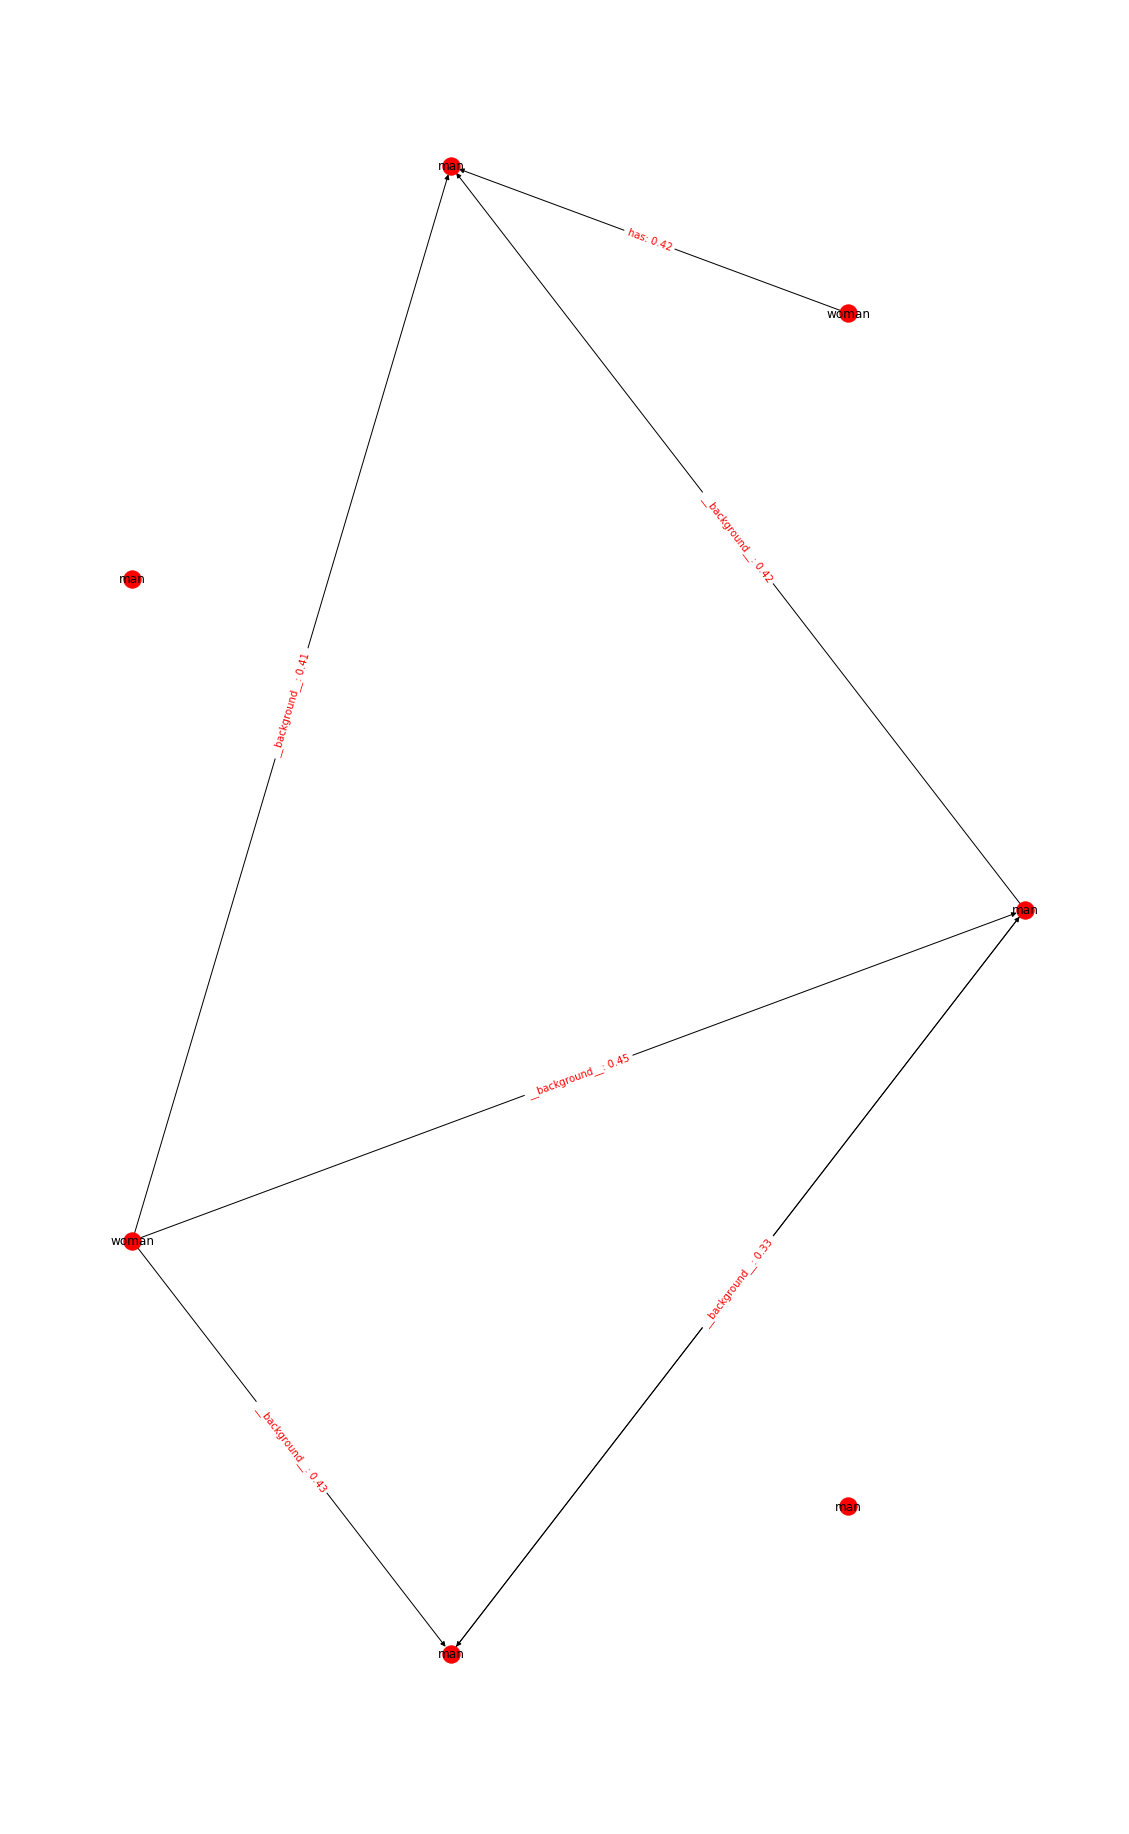

In [135]:
visualize_folder = "visualize"
if not os.path.exists(visualize_folder):
    os.mkdir(visualize_folder)
for i, (prediction, pred_prediction) in enumerate(zip(output, output_pred)):
    G, labeldict, edge_labeldict =  generategraph(img_id, prediction, pred_prediction, dataset.ind_to_classes, dataset.ind_to_predicates)
    json_graph.node_link_data(G)
    pos = nx.circular_layout(G)
    plt.figure(figsize=(15,25))
    nx.draw(G,pos, labels=labeldict, with_labels = True)
    nx.draw_networkx_edge_labels(
        G,pos,
        edge_labels=edge_labeldict,
        font_color='red'
    )
    plt.savefig(os.path.join(visualize_folder, "graph_{}.jpg".format(img_id)), format="JPG")
plt.show()